In [1]:
# Imports 
import os
import torch

In [2]:
from src.models import *
from src.dhand import *
from src.utils import *

In [3]:
device = torch.device('cpu')

## Data Loading

In [25]:
# Create datasets
df = read_source(
    r'F:\thesis\Thesis\Thesis\MECO\data/vib_case_dataset_ICMS Dataset.xlsx', 
    show_columns=False
)

df1,df2,dft  = double_data(
    df,
    ['VibGt_39VS4_1', 'VibGt_39VS4_2'],
    sample_length = 1024,
    overlap = 100
    
)

# files = save_to_temp_df(
#     df1,
#     df2,
#     dft,
#     dir = '/home/fdi/AliBagheriNejad/Thesis/MECO/code/TLT/temp'    
# )

In [5]:
# Read datafiles (If needed)
# df1 = pd.read_csv('/home/fdi/AliBagheriNejad/Thesis/MECO/code/TLT/temp/test_df_0.csv')
# df2 = pd.read_csv('/home/fdi/AliBagheriNejad/Thesis/MECO/code/TLT/temp/test_df_1.csv')
# df2 = pd.read_csv('/home/fdi/AliBagheriNejad/Thesis/MECO/code/TLT/temp/test_df_2.csv')

In [26]:
labels = dft.values[:,-1]
labels = np.datetime_as_string(labels, unit='D')

In [27]:
print(f'Shape of dataset 1 is {df1.shape}')
print(f'Shape of dataset 2 is {df2.shape}')
print(f'Shape of dataset time is {dft.shape}')


Shape of dataset 1 is (30, 1024)
Shape of dataset 2 is (30, 1024)
Shape of dataset time is (30, 1024)


In [28]:
from sklearn.preprocessing import StandardScaler
import joblib

In [29]:
X_scaled = np.zeros(shape=(df1.shape[0], df2.shape[1], 2))
X_scaled_self = np.zeros(shape=(df1.shape[0], df2.shape[1], 2))
df_list = [df1,df2]

s_dir = r'F:\thesis\Thesis\Thesis\MECO\code\TLT\weights/scaler'

s_names = ['scaler_f_3_final.pkl' , 'scaler_d_3_fianl.pkl']

for i in range(X_scaled.shape[2]):

    scaler = joblib.load(
        os.path.join(
            s_dir,
            s_names[i]
        )
    )

    X_scaled[:,:,i] = scaler.transform(df_list[i].values)
    X_scaled_self[:,:,i] = scaler.fit_transform(df_list[i].values)

g:\Anaconda3\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.6.1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
g:\Anaconda3\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.6.1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Dimentionality reduction of data itself

In [10]:
from umap import UMAP

In [ ]:
umap_reducer = UMAP(n_components=2, random_state=69)
embeddings = umap_reducer.fit_transform(np.nan_to_num(X_scaled).reshape(30,-1))

/home/fdi/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [11]:
from matplotlib.colors import ListedColormap
cmap = plt.get_cmap('gist_ncar')

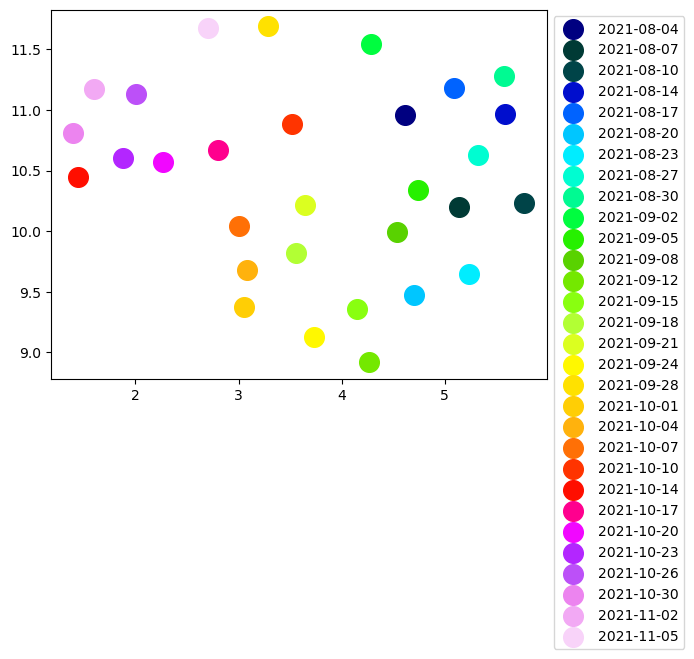

In [25]:
for i in range(np.unique(labels).shape[0]):  # Assuming 10 classes
    indices = labels == np.unique(labels)[i]
    plt.scatter(
        embeddings[indices, 0],
        embeddings[indices, 1],
        label=f'{np.unique(labels)[i]}' ,
        s=200,
        alpha=1,
        color=cmap(i/len(np.unique(labels)))
    )

plt.legend(loc='upper left', bbox_to_anchor=(1,1))

In [30]:
X_tensor = torch.tensor (X_scaled, dtype = torch.float32).to(device)
X_tensor_self = torch.tensor (X_scaled_self, dtype = torch.float32).to(device)

## Model training

In [13]:
model = Network(10,2, cons=2).to(device)

In [14]:
# Load weights
    # Mafaulda  
loaded_sd = torch.load(
        os.path.join(
            r'F:\thesis\Thesis\Thesis\MECO\code\TLT\weights',
            'mafda_test_1.pth'
        ), map_location=device
    )
del loaded_sd["conv.conv.weight"]
del loaded_sd["conv.conv.bias"]
    # CWRU
# loaded_sd = torch.load(
#         os.path.join(
#             '/home/fdi/AliBagheriNejad/Thesis/MECO/code/TLT/weights',
#             'mwdp_21.pth'
#         ), map_location=device
#     )
# loaded_sd = torch.load(
#         os.path.join(
#             '/home/fdi/AliBagheriNejad/Thesis/MECO/code/TLT/weights',
#             'cwdw_31.pth'
#         ), map_location=device
#     )

# Weight path
model.load_state_dict(loaded_sd)

<All keys matched successfully>

In [15]:
features_self = extract_second_features(model, X_tensor_self, device)
features = extract_second_features(model, X_tensor, device)
features_self[features_self.isnan()] = 0
features[features.isnan()] = 0

In [16]:
import umap

In [17]:
umap_reducer = umap.UMAP(n_components=2, random_state=69, n_neighbors=25)
embeddings_self = umap_reducer.fit_transform(features_self)
embeddings = umap_reducer.fit_transform(features)

g:\Anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [21]:
# Delete datasets
# data_files = ['/home/fdi/AliBagheriNejad/Thesis/MECO/code/TLT/temp/test_df_0.csv',
#  '/home/fdi/AliBagheriNejad/Thesis/MECO/code/TLT/temp/test_df_1.csv',
#  '/home/fdi/AliBagheriNejad/Thesis/MECO/code/TLT/temp/test_df_2.csv']
# clear_files(data_files)

2025-01-20 17:33:32,536 - INFO - Deleted file: /home/fdi/AliBagheriNejad/Thesis/MECO/code/TLT/temp/test_df_0.csv
2025-01-20 17:33:32,538 - INFO - Deleted file: /home/fdi/AliBagheriNejad/Thesis/MECO/code/TLT/temp/test_df_1.csv
2025-01-20 17:33:32,539 - INFO - Deleted file: /home/fdi/AliBagheriNejad/Thesis/MECO/code/TLT/temp/test_df_2.csv
2025-01-20 17:33:32,542 - INFO - Successfully deleted 3 file(s).


3

#### mwdp weights

With overlap 100

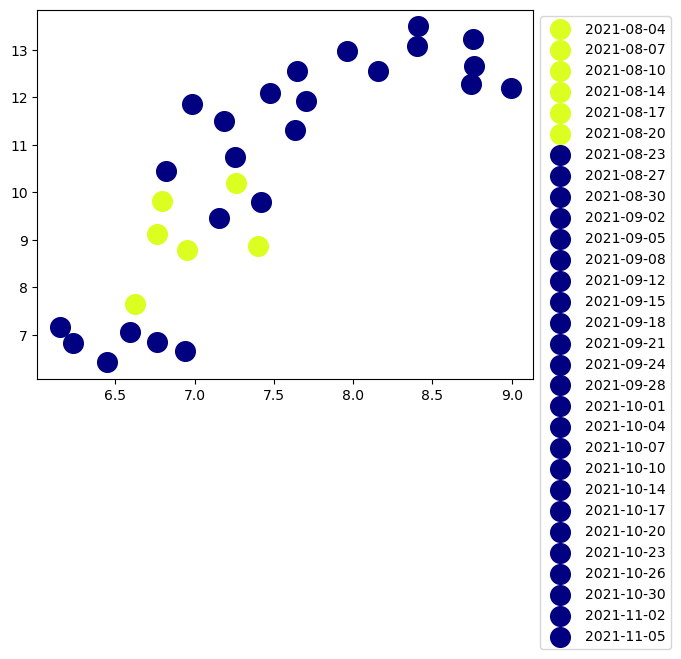

In [29]:
# Self scaled


for i in range(np.unique(labels).shape[0]):  # Assuming 10 classes
    indices = labels == np.unique(labels)[i]
    plt.scatter(
        embeddings_self[indices, 0],
        embeddings_self[indices, 1],
        label=f'{np.unique(labels)[i]}' ,
        s=200,
        alpha=1,
        color=colors[i]
    )

plt.legend(loc='upper left', bbox_to_anchor=(1,1))

In [33]:
colors = [cmap(0)  if i>13 else cmap(0.5) for i in range(len(labels))]
print(colors)

[(0.8573751723275831, 1.0, 0.12482388288648784, 1.0), (0.8573751723275831, 1.0, 0.12482388288648784, 1.0), (0.8573751723275831, 1.0, 0.12482388288648784, 1.0), (0.8573751723275831, 1.0, 0.12482388288648784, 1.0), (0.8573751723275831, 1.0, 0.12482388288648784, 1.0), (0.8573751723275831, 1.0, 0.12482388288648784, 1.0), (0.8573751723275831, 1.0, 0.12482388288648784, 1.0), (0.8573751723275831, 1.0, 0.12482388288648784, 1.0), (0.8573751723275831, 1.0, 0.12482388288648784, 1.0), (0.8573751723275831, 1.0, 0.12482388288648784, 1.0), (0.8573751723275831, 1.0, 0.12482388288648784, 1.0), (0.8573751723275831, 1.0, 0.12482388288648784, 1.0), (0.8573751723275831, 1.0, 0.12482388288648784, 1.0), (0.8573751723275831, 1.0, 0.12482388288648784, 1.0), (0.0, 0.0, 0.502, 1.0), (0.0, 0.0, 0.502, 1.0), (0.0, 0.0, 0.502, 1.0), (0.0, 0.0, 0.502, 1.0), (0.0, 0.0, 0.502, 1.0), (0.0, 0.0, 0.502, 1.0), (0.0, 0.0, 0.502, 1.0), (0.0, 0.0, 0.502, 1.0), (0.0, 0.0, 0.502, 1.0), (0.0, 0.0, 0.502, 1.0), (0.0, 0.0, 0.502,

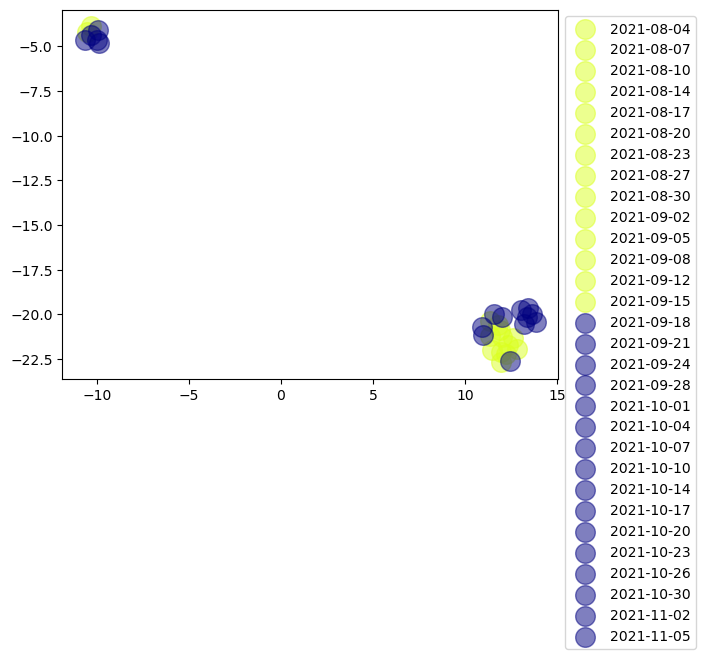

In [47]:
for i in range(np.unique(labels).shape[0]):  # Assuming 10 classes
    indices = labels == np.unique(labels)[i]
    plt.scatter(
        embeddings[indices, 0],
        embeddings[indices, 1],
        label=f'{np.unique(labels)[i]}' ,
        s=200,
        alpha=0.5,
        # color=cmap(i/len(np.unique(labels)))
        color=colors[i]
    )

plt.legend(loc='upper left', bbox_to_anchor=(1,1))

With overlap 500

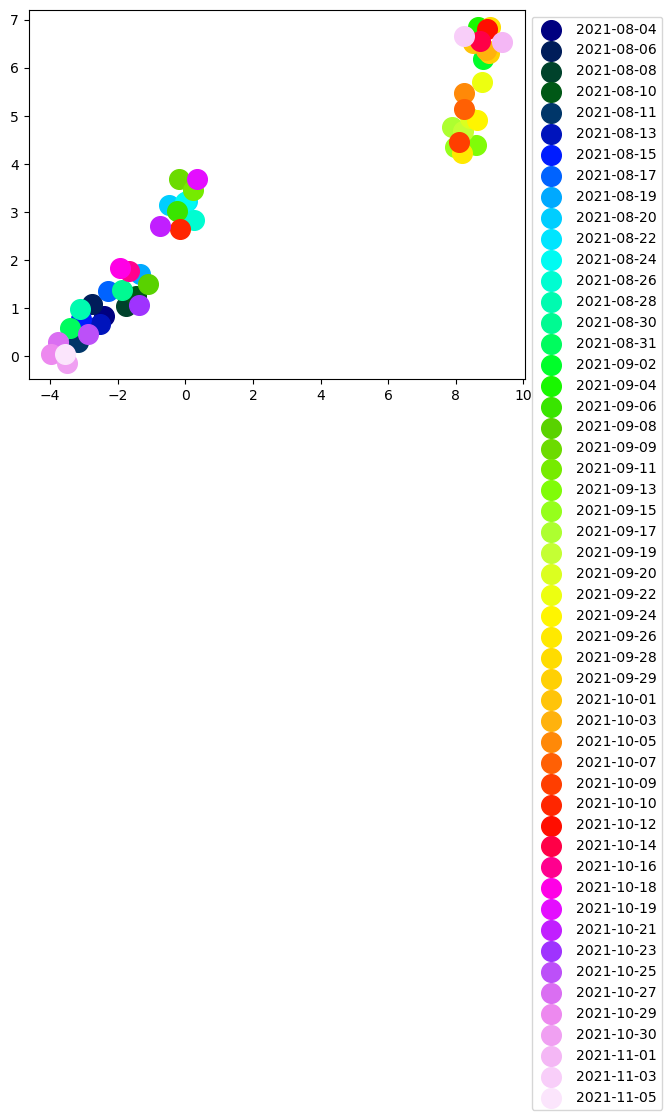

In [ ]:
# Self scaled
for i in range(np.unique(labels).shape[0]):  # Assuming 10 classes
    indices = labels == np.unique(labels)[i]
    plt.scatter(
        embeddings_self[indices, 0],
        embeddings_self[indices, 1],
        label=f'{np.unique(labels)[i]}' ,
        s=200,
        alpha=1,
        # color=cmap(i/len(np.unique(labels)))
        color=colors[i]
    )

plt.legend(loc='upper left', bbox_to_anchor=(1,1))

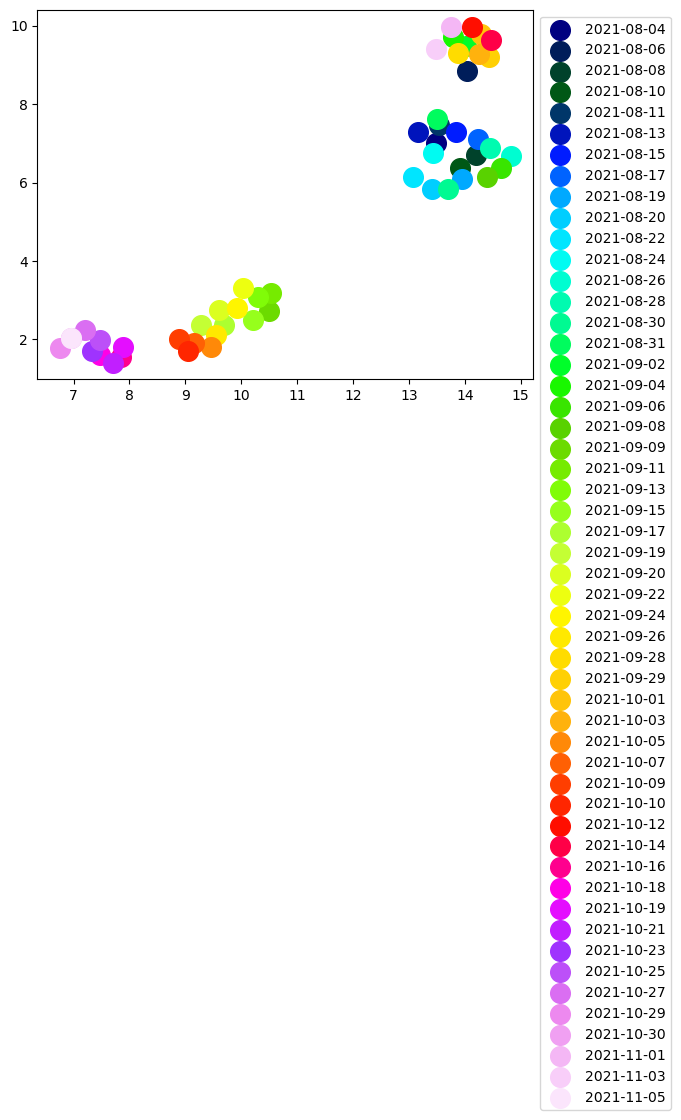

In [43]:
for i in range(np.unique(labels).shape[0]):  # Assuming 10 classes
    indices = labels == np.unique(labels)[i]
    plt.scatter(
        embeddings[indices, 0],
        embeddings[indices, 1],
        label=f'{np.unique(labels)[i]}' ,
        s=200,
        alpha=1,
        color=cmap(i/len(np.unique(labels)))
    )

plt.legend(loc='upper left', bbox_to_anchor=(1,1))

#### cwdw weights

With overlap 500

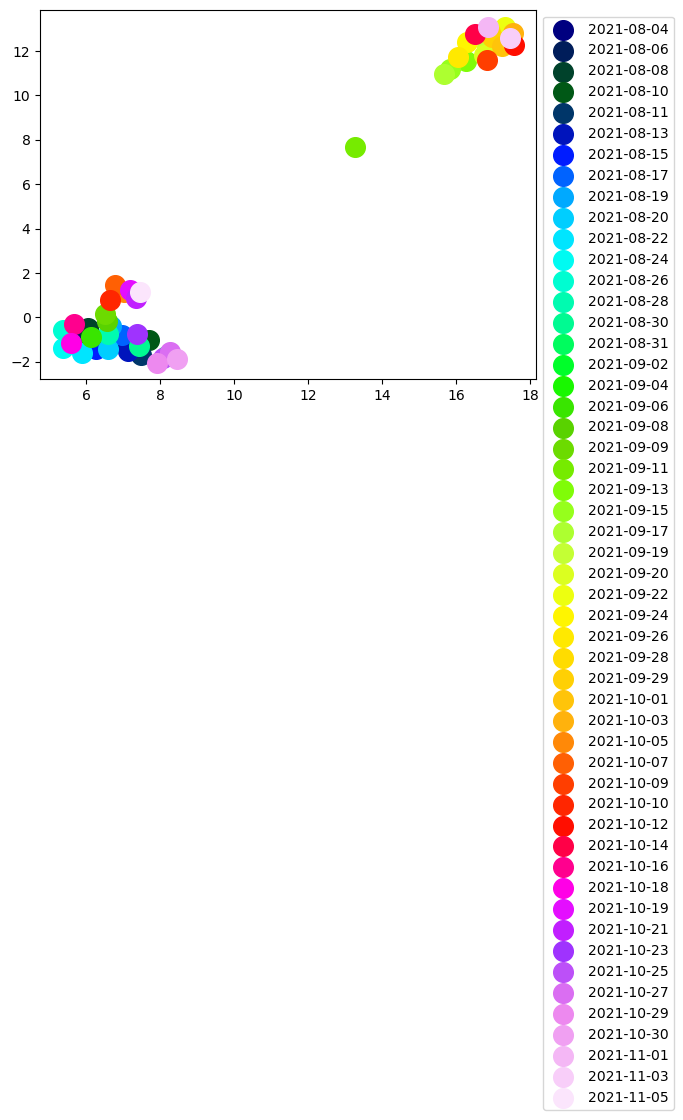

In [33]:
# Self scaled
for i in range(np.unique(labels).shape[0]):  # Assuming 10 classes
    indices = labels == np.unique(labels)[i]
    plt.scatter(
        embeddings_self[indices, 0],
        embeddings_self[indices, 1],
        label=f'{np.unique(labels)[i]}' ,
        s=200,
        alpha=1,
        color=cmap(i/len(np.unique(labels)))
    )

plt.legend(loc='upper left', bbox_to_anchor=(1,1))

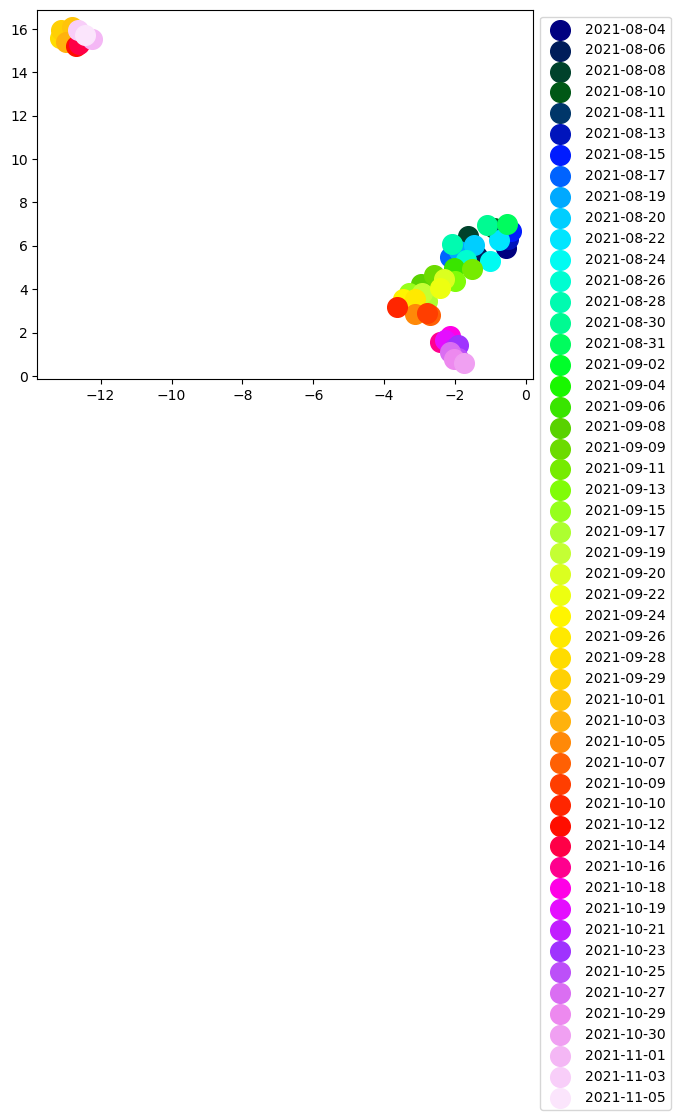

In [34]:
for i in range(np.unique(labels).shape[0]):  # Assuming 10 classes
    indices = labels == np.unique(labels)[i]
    plt.scatter(
        embeddings[indices, 0],
        embeddings[indices, 1],
        label=f'{np.unique(labels)[i]}' ,
        s=200,
        alpha=1,
        color=cmap(i/len(np.unique(labels)))
    )

plt.legend(loc='upper left', bbox_to_anchor=(1,1))

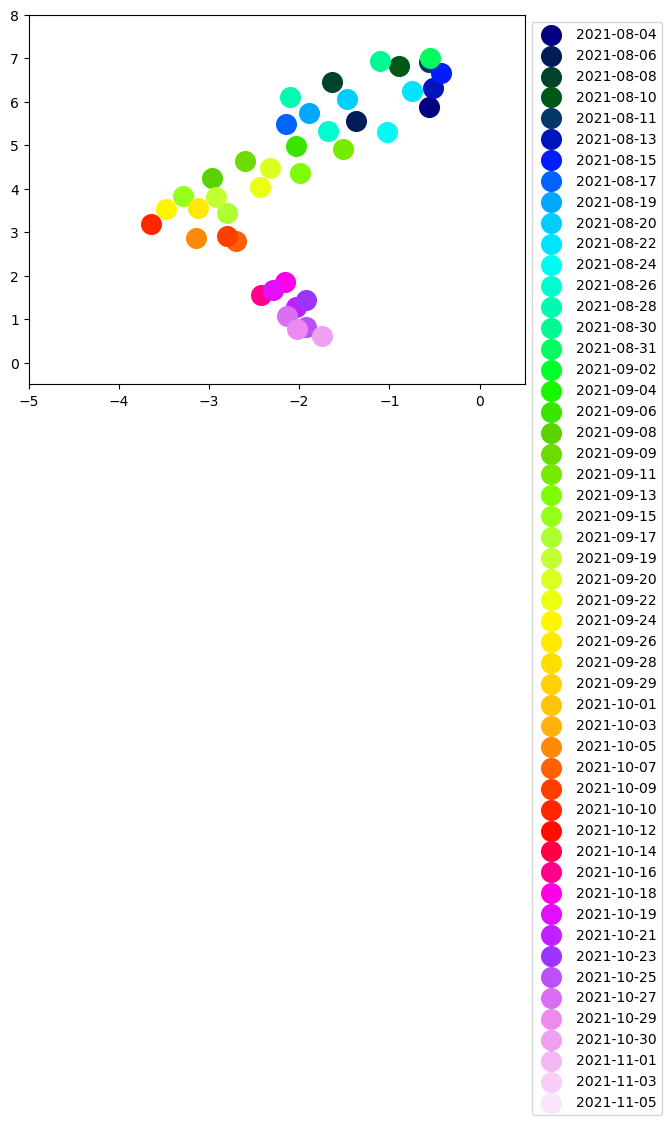

In [37]:
for i in range(np.unique(labels).shape[0]):  # Assuming 10 classes
    indices = labels == np.unique(labels)[i]
    plt.scatter(
        embeddings[indices, 0],
        embeddings[indices, 1],
        label=f'{np.unique(labels)[i]}' ,
        s=200,
        alpha=1,
        color=cmap(i/len(np.unique(labels)))
    )

plt.xlim((-5,0.5))
plt.ylim((-0.5, 8))
plt.legend(loc='upper left', bbox_to_anchor=(1,1))

With overlap 100

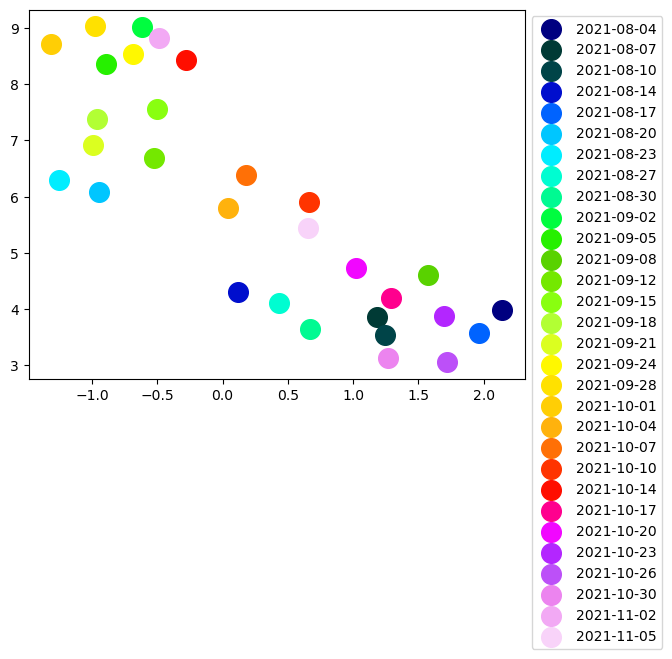

In [17]:
# Self scaled
for i in range(np.unique(labels).shape[0]):  # Assuming 10 classes
    indices = labels == np.unique(labels)[i]
    plt.scatter(
        embeddings_self[indices, 0],
        embeddings_self[indices, 1],
        label=f'{np.unique(labels)[i]}' ,
        s=200,
        alpha=1,
        color=cmap(i/len(np.unique(labels)))
    )

plt.legend(loc='upper left', bbox_to_anchor=(1,1))

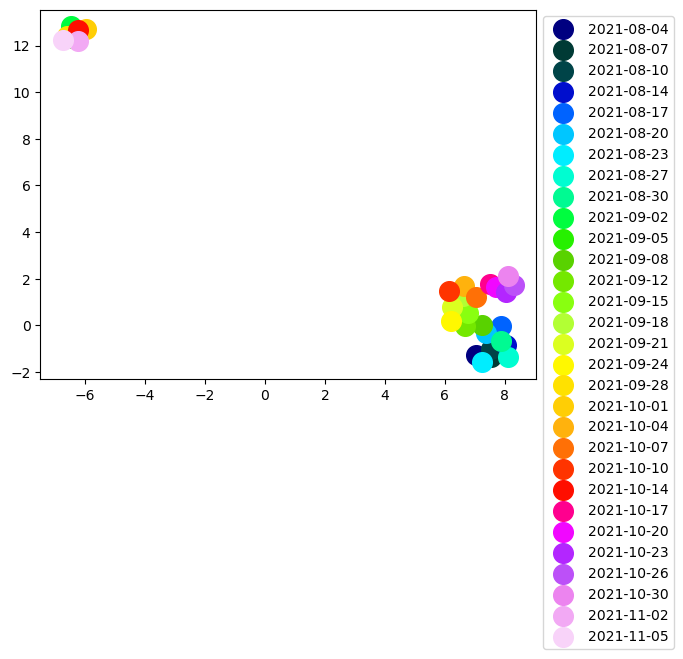

In [18]:
for i in range(np.unique(labels).shape[0]):  # Assuming 10 classes
    indices = labels == np.unique(labels)[i]
    plt.scatter(
        embeddings[indices, 0],
        embeddings[indices, 1],
        label=f'{np.unique(labels)[i]}' ,
        s=200,
        alpha=1,
        color=cmap(i/len(np.unique(labels)))
    )

plt.legend(loc='upper left', bbox_to_anchor=(1,1))

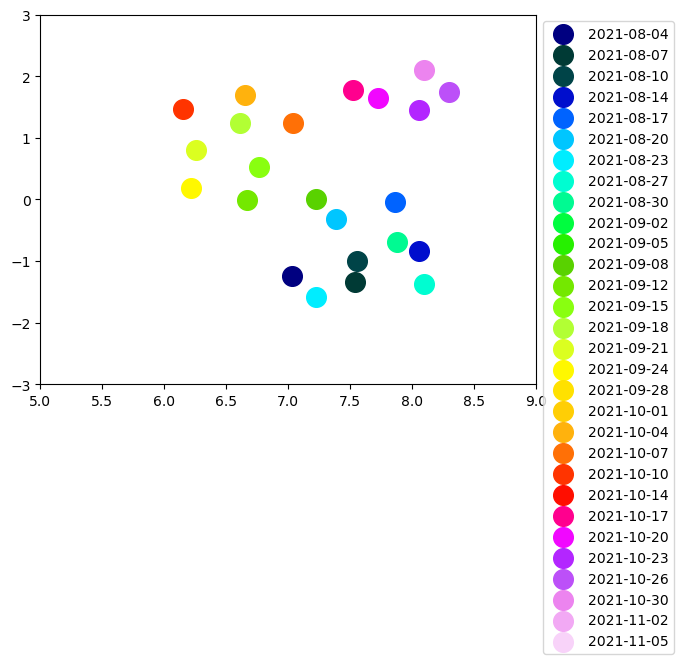

In [19]:
for i in range(np.unique(labels).shape[0]):  # Assuming 10 classes
    indices = labels == np.unique(labels)[i]
    plt.scatter(
        embeddings[indices, 0],
        embeddings[indices, 1],
        label=f'{np.unique(labels)[i]}' ,
        s=200,
        alpha=1,
        color=cmap(i/len(np.unique(labels)))
    )

plt.xlim((5,9))
plt.ylim((-3,3))
plt.legend(loc='upper left', bbox_to_anchor=(1,1))

#### ICMS (2021)

With 100 overlap

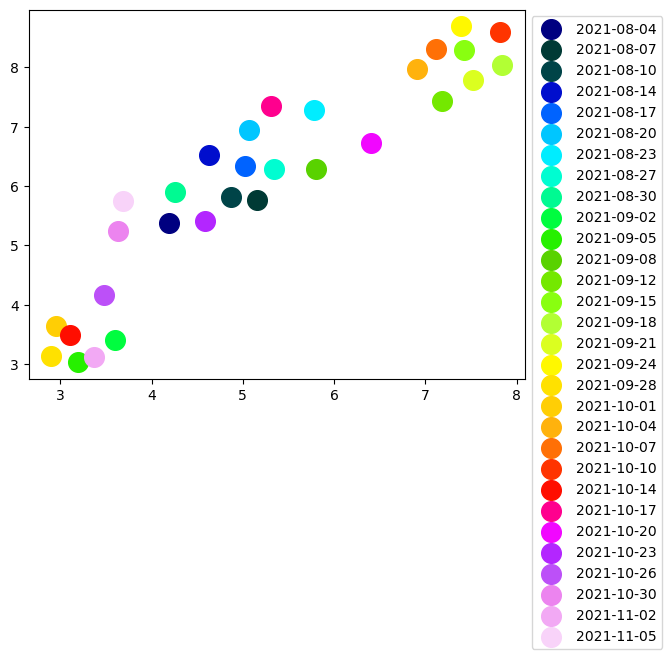

In [29]:
# Self scaled
for i in range(np.unique(labels).shape[0]):  # Assuming 10 classes
    indices = labels == np.unique(labels)[i]
    plt.scatter(
        embeddings_self[indices, 0],
        embeddings_self[indices, 1],
        label=f'{np.unique(labels)[i]}' ,
        s=200,
        alpha=1,
        color=cmap(i/len(np.unique(labels)))
    )

plt.legend(loc='upper left', bbox_to_anchor=(1,1))

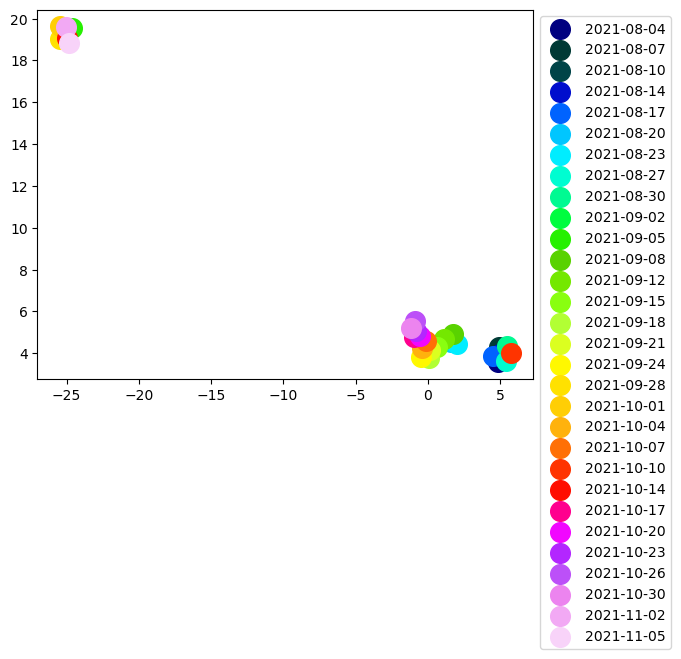

In [30]:
for i in range(np.unique(labels).shape[0]):  # Assuming 10 classes
    indices = labels == np.unique(labels)[i]
    plt.scatter(
        embeddings[indices, 0],
        embeddings[indices, 1],
        label=f'{np.unique(labels)[i]}' ,
        s=200,
        alpha=1,
        color=cmap(i/len(np.unique(labels)))
    )

plt.legend(loc='upper left', bbox_to_anchor=(1,1))

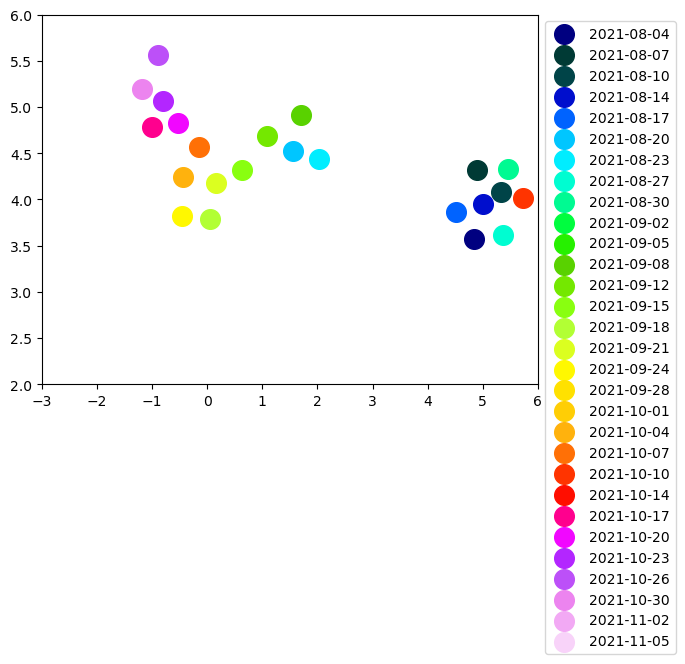

In [31]:
for i in range(np.unique(labels).shape[0]):  # Assuming 10 classes
    indices = labels == np.unique(labels)[i]
    plt.scatter(
        embeddings[indices, 0],
        embeddings[indices, 1],
        label=f'{np.unique(labels)[i]}' ,
        s=200,
        alpha=1,
        color=cmap(i/len(np.unique(labels)))
    )

plt.xlim((-3,6))
plt.ylim((2,6))
plt.legend(loc='upper left', bbox_to_anchor=(1,1))

With 500 overlap

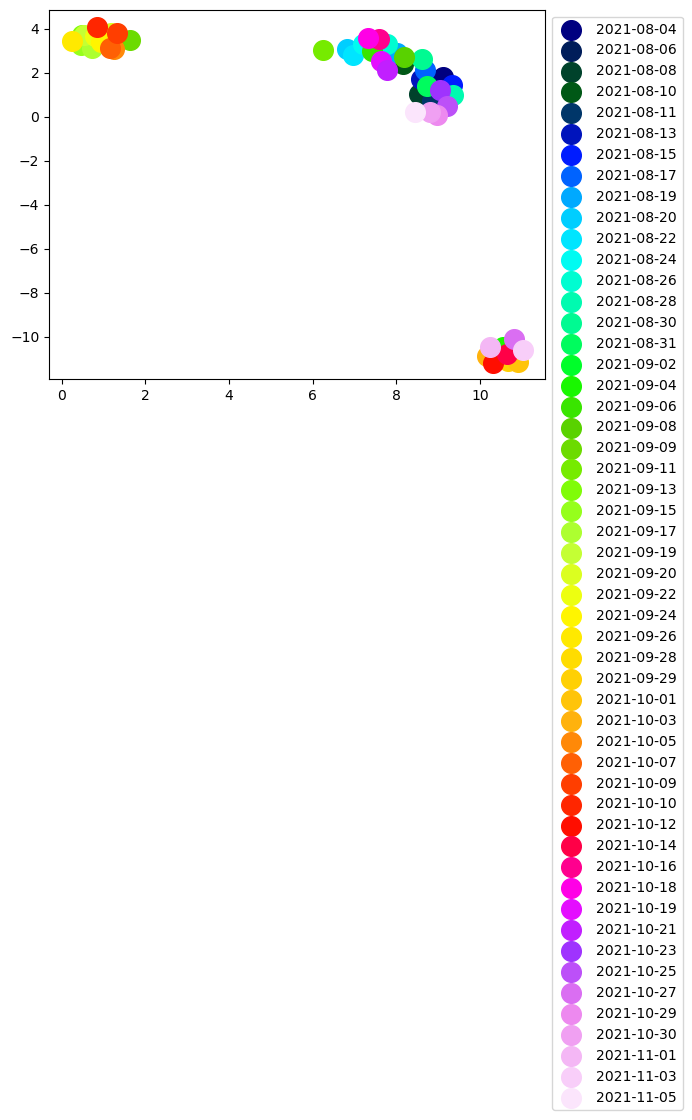

In [19]:
# Self scaled
for i in range(np.unique(labels).shape[0]):  # Assuming 10 classes
    indices = labels == np.unique(labels)[i]
    plt.scatter(
        embeddings_self[indices, 0],
        embeddings_self[indices, 1],
        label=f'{np.unique(labels)[i]}' ,
        s=200,
        alpha=1,
        color=cmap(i/len(np.unique(labels)))
    )

plt.legend(loc='upper left', bbox_to_anchor=(1,1))

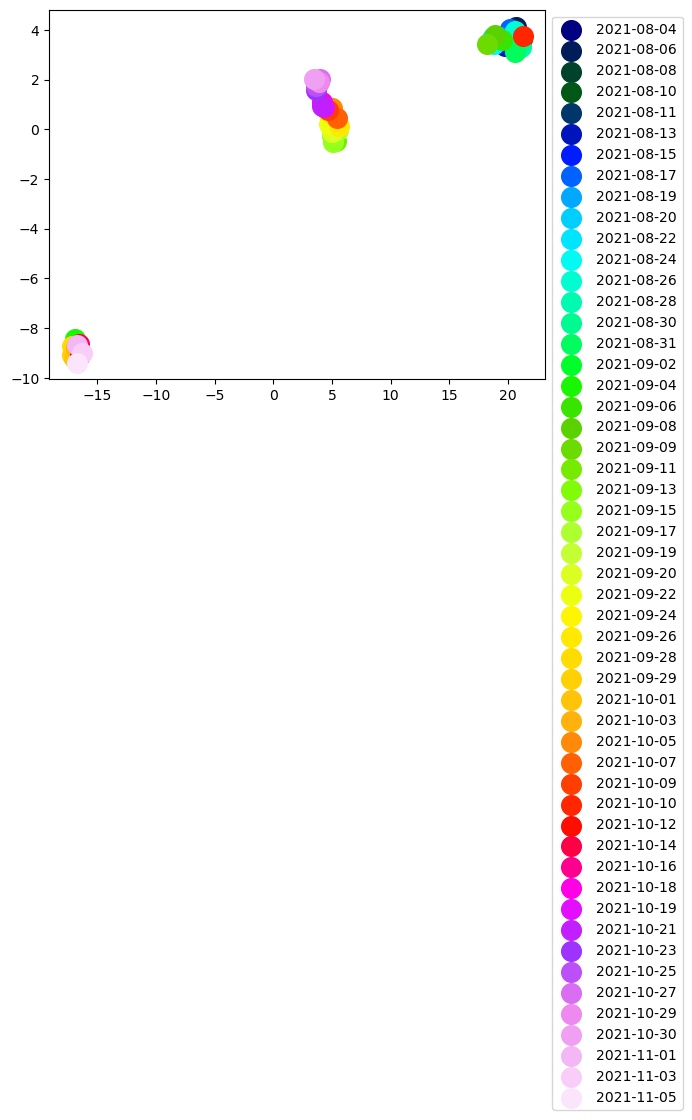

In [20]:
for i in range(np.unique(labels).shape[0]):  # Assuming 10 classes
    indices = labels == np.unique(labels)[i]
    plt.scatter(
        embeddings[indices, 0],
        embeddings[indices, 1],
        label=f'{np.unique(labels)[i]}' ,
        s=200,
        alpha=1,
        color=cmap(i/len(np.unique(labels)))
    )

plt.legend(loc='upper left', bbox_to_anchor=(1,1))

With no overlap

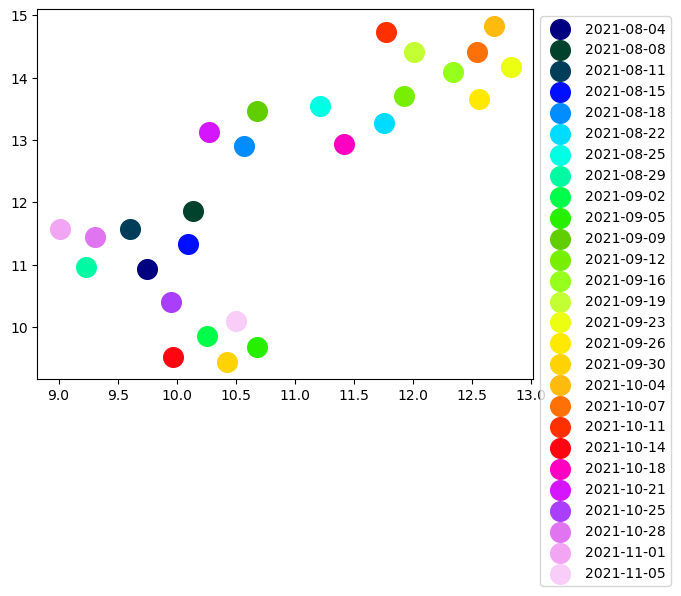

In [ ]:
# Self scaled
for i in range(np.unique(labels).shape[0]):  # Assuming 10 classes
    indices = labels == np.unique(labels)[i]
    plt.scatter(
        embeddings_self[indices, 0],
        embeddings_self[indices, 1],
        label=f'{np.unique(labels)[i]}' ,
        s=200,
        alpha=1,
        color=cmap(i/len(np.unique(labels)))
    )

plt.legend(loc='upper left', bbox_to_anchor=(1,1))

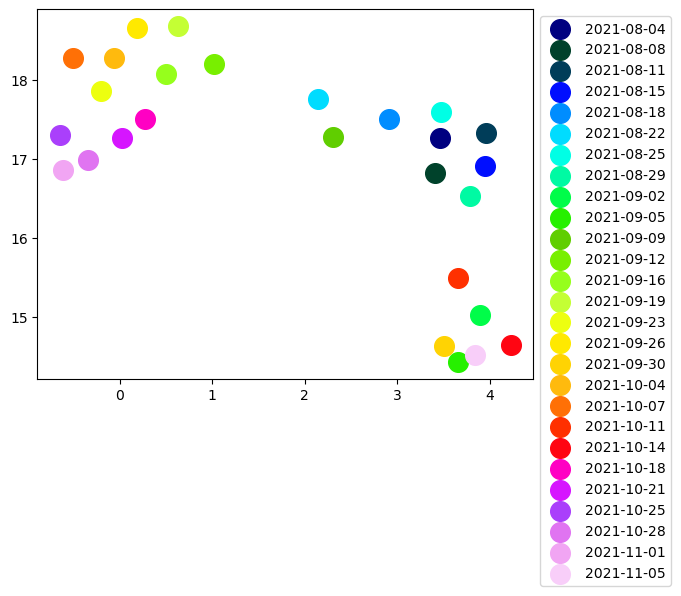

In [35]:
for i in range(np.unique(labels).shape[0]):  # Assuming 10 classes
    indices = labels == np.unique(labels)[i]
    plt.scatter(
        embeddings[indices, 0],
        embeddings[indices, 1],
        label=f'{np.unique(labels)[i]}' ,
        s=200,
        alpha=1,
        color=cmap(i/len(np.unique(labels)))
    )

plt.legend(loc='upper left', bbox_to_anchor=(1,1))

## MaFaulDa (proposed)

In [31]:
model = Network(10,2, cons=2).to(device)
# Load weights
    # Mafaulda  
loaded_sd = torch.load(
        os.path.join(
            r'F:\thesis\Thesis\Thesis\MECO\code\TLT\weights',
            'mafda_test_2.pth'
        ), map_location=device
    )
del loaded_sd["conv.conv.weight"]
del loaded_sd["conv.conv.bias"]
    # CWRU
# loaded_sd = torch.load(
#         os.path.join(
#             '/home/fdi/AliBagheriNejad/Thesis/MECO/code/TLT/weights',
#             'mwdp_21.pth'
#         ), map_location=device
#     )
# loaded_sd = torch.load(
#         os.path.join(
#             '/home/fdi/AliBagheriNejad/Thesis/MECO/code/TLT/weights',
#             'cwdw_31.pth'
#         ), map_location=device
#     )

# Weight path
model.load_state_dict(loaded_sd)
features_self = extract_second_features(model, X_tensor_self, device)
features = extract_second_features(model, X_tensor, device)
features_self[features_self.isnan()] = 0
features[features.isnan()] = 0


In [32]:

umap_reducer = umap.UMAP(n_components=2, random_state=69, n_neighbors=12)
embeddings_self = umap_reducer.fit_transform(features_self)
embeddings = umap_reducer.fit_transform(features)


g:\Anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


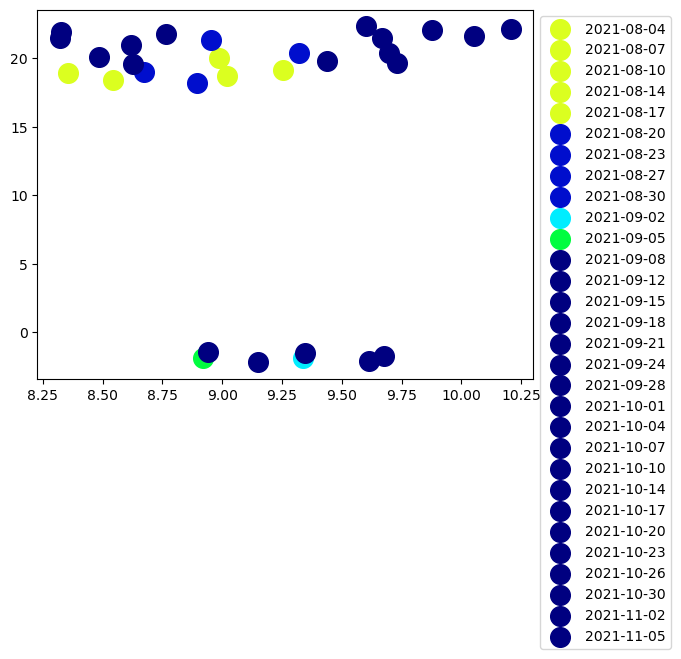

In [42]:

colors = [cmap(0)  if i>9 else cmap(0.5) for i in range(len(labels))]

colors[9] = cmap(0.2)
colors[10] = cmap(0.3)
# colors[11] = cmap(0.4)
# colors[12] = cmap(0.6)
for j in range(5,9):
    colors[j] = cmap(0.1)

for i in range(np.unique(labels).shape[0]):  # Assuming 10 classes
    indices = labels == np.unique(labels)[i]
    plt.scatter(
        embeddings[indices, 0],
        embeddings[indices, 1],
        label=f'{np.unique(labels)[i]}' ,
        s=200,
        alpha=1,
        # color=cmap(i/len(np.unique(labels))),
        color=colors[i]
    )

# plt.xlim([6,12])
# plt.ylim([-5,7])

plt.legend(loc='upper left', bbox_to_anchor=(1,1))

## MaFaulDa (Usual)

In [22]:
model = NetworkNoReg(10,2).to(device)
# Load weights
    # Mafaulda  
loaded_sd = torch.load(
        os.path.join(
            '/home/fdi/AliBagheriNejad/Thesis/MECO/code/TLT/weights',
            'mafda_noreg_2.pth'
        ), map_location=device
    )
del loaded_sd["conv.conv.weight"]
del loaded_sd["conv.conv.bias"]
    # CWRU
# loaded_sd = torch.load(
#         os.path.join(
#             '/home/fdi/AliBagheriNejad/Thesis/MECO/code/TLT/weights',
#             'mwdp_21.pth'
#         ), map_location=device
#     )
# loaded_sd = torch.load(
#         os.path.join(
#             '/home/fdi/AliBagheriNejad/Thesis/MECO/code/TLT/weights',
#             'cwdw_31.pth'
#         ), map_location=device
#     )

# Weight path
model.load_state_dict(loaded_sd)
features = extract_features(model, X_tensor, device)
features[features.isnan()] = 0


/tmp/ipykernel_7129/2397059451.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_sd = torch.load(


In [ ]:
# # Plot the results
# plt.figure(figsize=(10,10))
# for i in range(10):  # Assuming 10 classes
#   indices = y_test == i
#   plt.scatter(embeddings[indices, 0], embeddings[indices, 1],s=100, label=f'{i}', alpha=0.5)

# plt.xlabel('t-SNE Dimension 1', fontproperties=font_prop, fontsize=25)
# plt.ylabel('t-SNE Dimension 2', fontproperties=font_prop, fontsize=25)
# # plt.title('Dynamic prunning on Test', fontproperties=font_prop, fontsize=40)
# # plt.legend(fontsize=30)
# plt.xticks(fontproperties=font_prop, fontsize=20)
# plt.yticks(fontproperties=font_prop, fontsize=20)
# plt.legend(fontsize =20, loc='upper left', bbox_to_anchor=(1.05, 1))
# plt.savefig("l1_prop.pdf", format="pdf", bbox_inches='tight')

/home/fdi/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


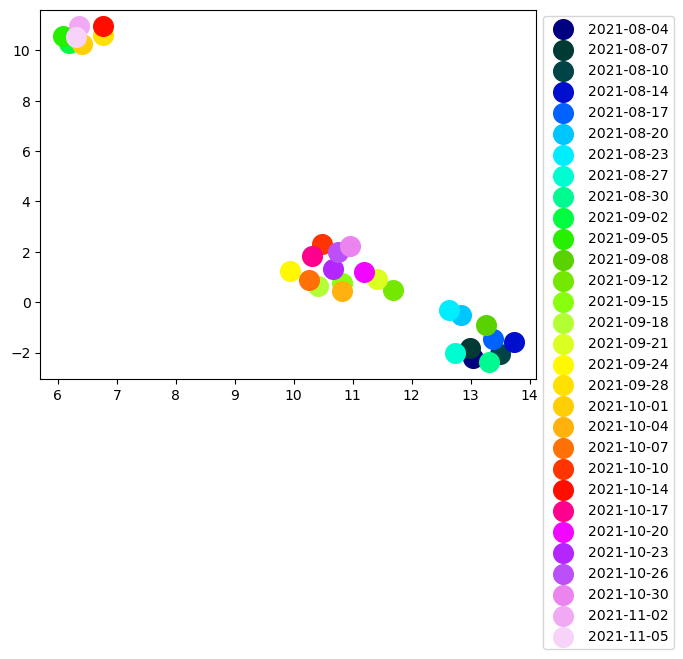

In [36]:

umap_reducer = UMAP(n_components=2, random_state=69,n_neighbors=13)
embeddings = umap_reducer.fit_transform(features)

for i in range(np.unique(labels).shape[0]):  # Assuming 10 classes
    indices = labels == np.unique(labels)[i]
    plt.scatter(
        embeddings[indices, 0],
        embeddings[indices, 1],
        label=f'{np.unique(labels)[i]}' ,
        s=200,
        alpha=1,
        color=cmap(i/len(np.unique(labels)))
    )

plt.legend(loc='upper left', bbox_to_anchor=(1,1))

In [35]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [18]:
# Initialize PCA with 2 components
pca_reducer = PCA(n_components=2, random_state=69)

# Fit and transform the features
embeddings = pca_reducer.fit_transform(features)

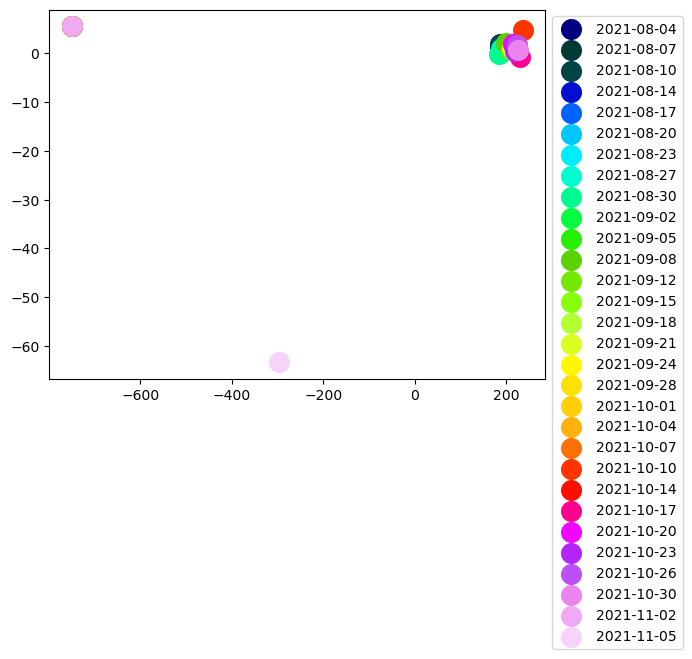

In [21]:
for i in range(np.unique(labels).shape[0]):  # Assuming 10 classes
    indices = labels == np.unique(labels)[i]
    plt.scatter(
        embeddings[indices, 0],
        embeddings[indices, 1],
        label=f'{np.unique(labels)[i]}' ,
        s=200,
        alpha=1,
        color=cmap(i/len(np.unique(labels)))
    )
# plt.xlim((100, 300))
# plt.ylim((-10, 10))
plt.legend(loc='upper left', bbox_to_anchor=(1,1))

## new way

Our model

In [23]:
model.eval()

a = model(X_tensor)
_,a = torch.max(a,1)
a = a.cpu().detach().numpy()

In [24]:
print(a)

[7 7 7 7 7 7 7 7 7 0 0 7 7 7 7 7 7 0 0 7 7 7 0 7 7 7 7 7 0 7]


usual model

In [25]:
model = NetworkNoReg(10,2).to(device)
# Load weights
    # Mafaulda  
loaded_sd = torch.load(
        os.path.join(
            '/home/fdi/AliBagheriNejad/Thesis/MECO/code/TLT/weights',
            'mafda_noreg_2.pth'
        ), map_location=device
    )
del loaded_sd["conv.conv.weight"]
del loaded_sd["conv.conv.bias"]
    # CWRU
# loaded_sd = torch.load(
#         os.path.join(
#             '/home/fdi/AliBagheriNejad/Thesis/MECO/code/TLT/weights',
#             'mwdp_21.pth'
#         ), map_location=device
#     )
# loaded_sd = torch.load(
#         os.path.join(
#             '/home/fdi/AliBagheriNejad/Thesis/MECO/code/TLT/weights',
#             'cwdw_31.pth'
#         ), map_location=device
#     )

# Weight path
model.load_state_dict(loaded_sd)
features = extract_features(model, X_tensor, device)
features[features.isnan()] = 0

/tmp/ipykernel_14887/3605259658.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_sd = torch.load(


In [26]:
model.eval()

a = model(X_tensor)
_,a = torch.max(a,1)
a = a.cpu().detach().numpy()

In [27]:
print(a)

[7 7 7 7 7 7 7 7 7 0 0 7 7 7 7 7 7 0 0 7 7 7 0 7 7 7 7 7 0 7]


## Trick 2 (gen data)

### Generating data

In [24]:
total_length = 100000
x = np.linspace(0,10,total_length)
ch_1 = np.sin(x*10)*2
ch_2 = np.cos(x*10)*2

np.random.seed(69)
noise_1 = np.random.rand(total_length,)
noise_1 -= np.mean(noise_1)
np.random.seed(85)
noise_2 = np.random.rand(total_length,)
noise_2 -= np.mean(noise_2)

In [25]:
ch_1_f1 = ch_1 + noise_1
ch_2_f2 = ch_2 + noise_2

In [26]:
df_ch1 = create_dataset(pd.Series(ch_1), 1024, 0)
df_ch2 = create_dataset(pd.Series(ch_2), 1024, 0)
df_ch1f = create_dataset(pd.Series(ch_1_f1), 1024, 0)
df_ch2f = create_dataset(pd.Series(ch_2_f2), 1024, 0)

In [42]:
cl_1 = np.zeros(shape = (df_ch1.shape[0],df_ch1.shape[1],2))
cl_2 = np.zeros(shape = (df_ch1.shape[0],df_ch1.shape[1],2))
cl_3 = np.zeros(shape = (df_ch1.shape[0],df_ch1.shape[1],2))

cl_1[:,:,0] = df_ch1
cl_1[:,:,1] = df_ch2
cl_2[:,:,0] = df_ch1f
cl_2[:,:,1] = df_ch2*0
cl_3[:,:,0] = df_ch1
cl_3[:,:,1] = df_ch1f

X_gen = np.concatenate([cl_1, cl_2, cl_3], axis=0)

label_1 = np.zeros(cl_1.shape[0],)
label_2 = np.ones(cl_2.shape[0],)
label_3 = np.ones(cl_3.shape[0],)*2

y_gen = np.hstack((label_1,label_2, label_3))

In [43]:
s_dir = '/home/fdi/AliBagheriNejad/Thesis/MECO/code/TLT/weights/scaler'
X_scaled = np.zeros_like(X_gen)

for i in range(X_gen.shape[2]):

    scaler = joblib.load(
        os.path.join(
            s_dir,
            f'scaler_p_mfda_01_{i}.pkl'
        )
    )

    X_scaled[:,:,i] = scaler.transform(X_gen[:,:,i])

/home/fdi/anaconda3/lib/python3.12/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.6.0 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/fdi/anaconda3/lib/python3.12/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.6.0 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [44]:
X_tensor = torch.tensor(X_scaled, dtype=torch.float32).to(device)
y_gen = torch.tensor(y_gen, dtype=torch.int8).to(device)

In [45]:
model_1 = Network(10,2,cons=2).to(device)
loaded_sd = torch.load(
        os.path.join(
            '/home/fdi/AliBagheriNejad/Thesis/MECO/code/TLT/weights',
            'mafda_test_1.pth'
        ), map_location=device
    )
del loaded_sd["conv.conv.weight"]
del loaded_sd["conv.conv.bias"]
model_1.load_state_dict(loaded_sd)

model_2 = NetworkNoReg(10,2).to(device)
loaded_sd = torch.load(
        os.path.join(
            '/home/fdi/AliBagheriNejad/Thesis/MECO/code/TLT/weights',
            'mafda_noreg_2.pth'
        ), map_location=device
    )
del loaded_sd["conv.conv.weight"]
del loaded_sd["conv.conv.bias"]
model_2.load_state_dict(loaded_sd)

/tmp/ipykernel_6820/2963483970.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_sd = torch.load(
/tmp/ipykernel_6820/2963483970.py:13: FutureWarning: You are using

<All keys matched successfully>

In [46]:
model_1.eval()
with torch.no_grad():
    x = X_tensor.to(device)
    if model_1.in_ch == 1:
        x_input = x.view(x.shape[0], 1, x.shape[1])  # Reshape input to (batch_size, channels, length)
    else:
        x_input = x.view(x.shape[0], x.shape[2] , x.shape[1])
    x = model_1.feature_extractor_1(x_input)
    x = model_1.regressor(x)
    x = x.unsqueeze(-1)
    print(torch.mean(x, dim=0))
    print(torch.var(x,dim=0))
    re_out = x.cpu().detach().numpy()


inp_1 = re_out[:,0].reshape(-1,)
inp_2 = re_out[:,1].reshape(-1,)
lab = y_gen.cpu().detach().numpy()
# Convert to a pandas DataFrame
df = pd.DataFrame({'drive_end': inp_1, 'fan_end':inp_2, 'label': lab})

tensor([[0.6037],
        [0.3963]])
tensor([[0.0182],
        [0.0182]])


/home/fdi/AliBagheriNejad/Thesis/MECO/code/TLT/src/utils.py:185: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=15)


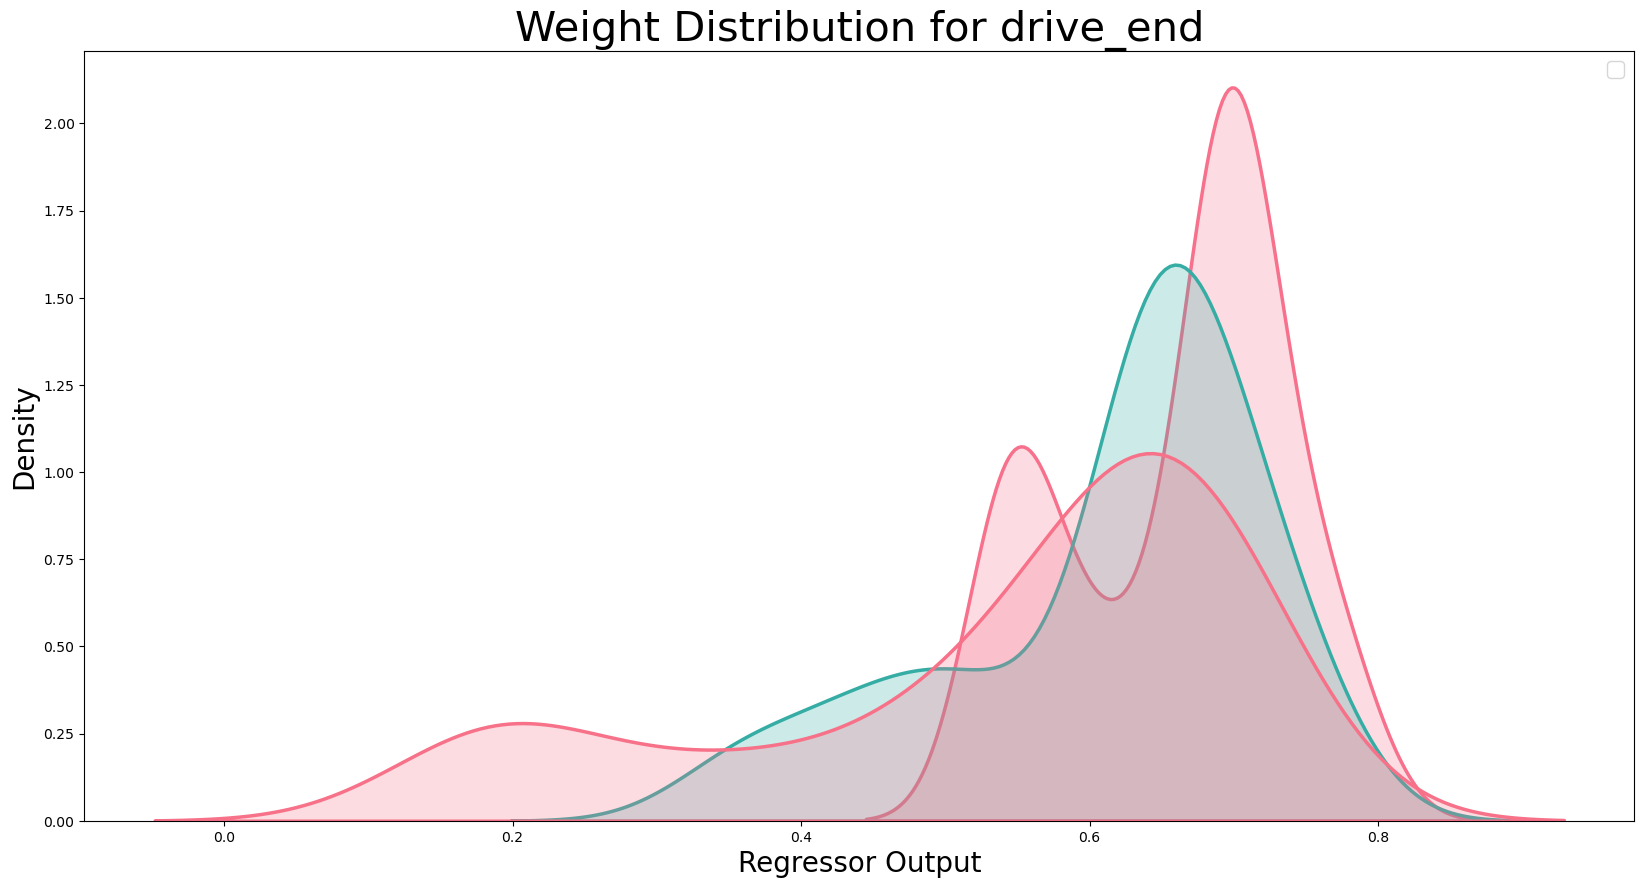

In [47]:
plot_weight_distribution(df,'drive_end')

In [48]:
model_1.eval()
model_2.eval()

feat_1 = extract_second_features(model_1, X_tensor, device)
feat_2 = extract_features(model_2, X_tensor, device)

In [32]:
umap_reducer = UMAP(n_components=2, random_state=69, n_neighbors=2)
embeddings_1 = umap_reducer.fit_transform(feat_1)
embeddings_2 = umap_reducer.fit_transform(feat_2)
embeddings_3 = umap_reducer.fit_transform(X_tensor.cpu().detach().numpy().reshape(97*3,-1))
labels = y_gen

ems = [embeddings_1, embeddings_2, embeddings_3]

for p in ems:
    embeddings = p
    plt.figure()
    for i in range(np.unique(labels).shape[0]):  # Assuming 10 classes
        indices = labels == np.unique(labels)[i]
        plt.scatter(
            embeddings[indices, 0],
            embeddings[indices, 1],
            label=f'{np.unique(labels)[i]}' ,
            s=50,
            alpha=1,
            color=cmap(i/len(np.unique(labels)))
        )

    plt.legend(loc='upper left', bbox_to_anchor=(1,1))

NameError: name 'UMAP' is not defined

In [33]:
from sklearn.manifold import TSNE # show them with TSNE

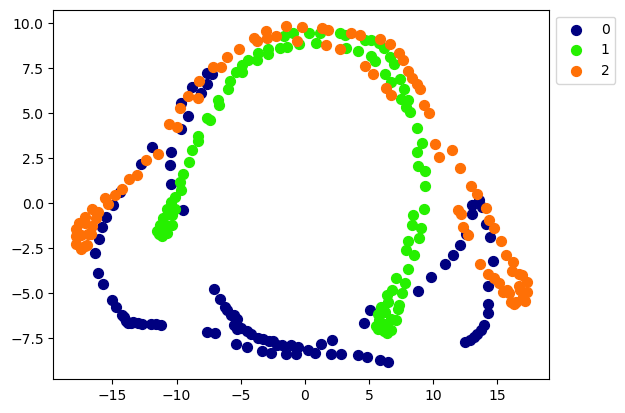

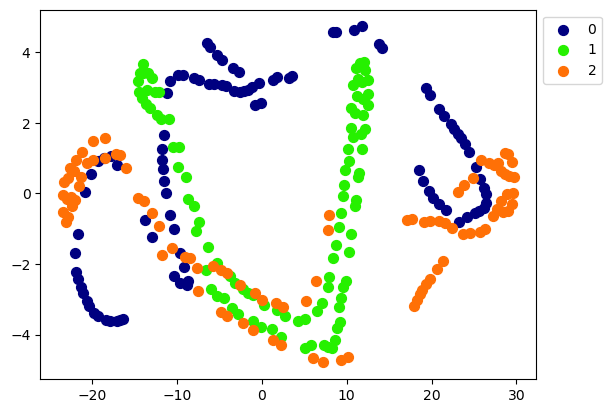

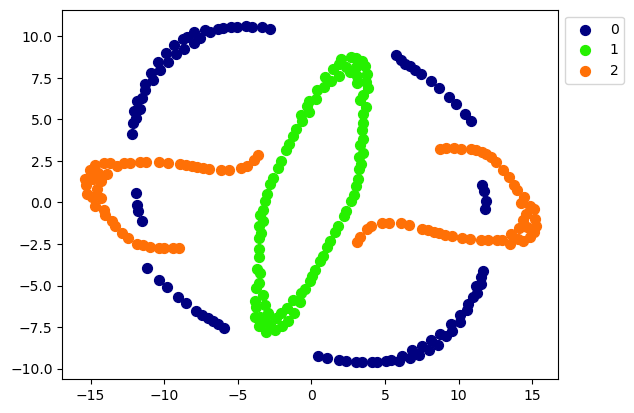

In [49]:
tsne_reducer = TSNE(n_components=2, random_state=69)
embeddings_1 = tsne_reducer.fit_transform(feat_1)
embeddings_2 = tsne_reducer.fit_transform(feat_2)
embeddings_3 = tsne_reducer.fit_transform(X_tensor.cpu().detach().numpy().reshape(97*3,-1))
labels = y_gen


ems = [embeddings_1, embeddings_2, embeddings_3]

for p in ems:
    embeddings = p
    plt.figure()
    for i in range(np.unique(labels).shape[0]):  # Assuming 10 classes
        indices = labels == np.unique(labels)[i]
        plt.scatter(
            embeddings[indices, 0],
            embeddings[indices, 1],
            label=f'{np.unique(labels)[i]}' ,
            s=50,
            alpha=1,
            color=cmap(i/len(np.unique(labels)))
        )

    plt.legend(loc='upper left', bbox_to_anchor=(1,1))

In [50]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report

In [51]:
# lr_classifier = LogisticRegression()
lr_classifier = SVC()

lr_classifier.fit(feat_1, y_gen)

y_pred = lr_classifier.predict(feat_1)

cm = classification_report(y_pred, y_gen)
print (cm)

              precision    recall  f1-score   support

           0       0.67      0.83      0.74        78
           1       0.87      0.79      0.83       106
           2       0.77      0.70      0.74       107

    accuracy                           0.77       291
   macro avg       0.77      0.78      0.77       291
weighted avg       0.78      0.77      0.77       291



In [52]:
# lr_classifier = LogisticRegression()
lr_classifier = SVC()

lr_classifier.fit(feat_2, y_gen)

y_pred = lr_classifier.predict(feat_2)

cm = classification_report(y_pred, y_gen)
print (cm)

              precision    recall  f1-score   support

           0       0.62      0.67      0.65        89
           1       0.77      0.66      0.71       113
           2       0.63      0.69      0.66        89

    accuracy                           0.67       291
   macro avg       0.67      0.67      0.67       291
weighted avg       0.68      0.67      0.68       291



In [53]:
from sklearn.decomposition import PCA

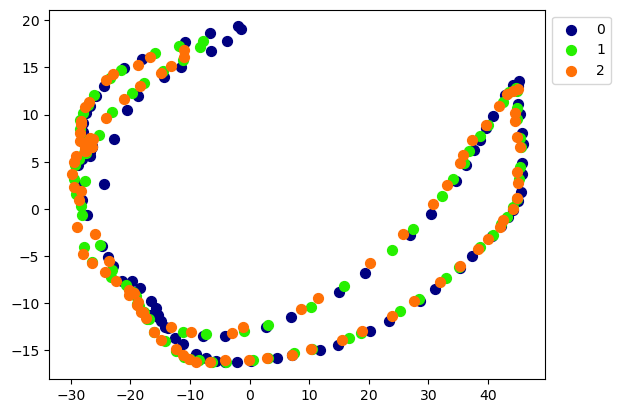

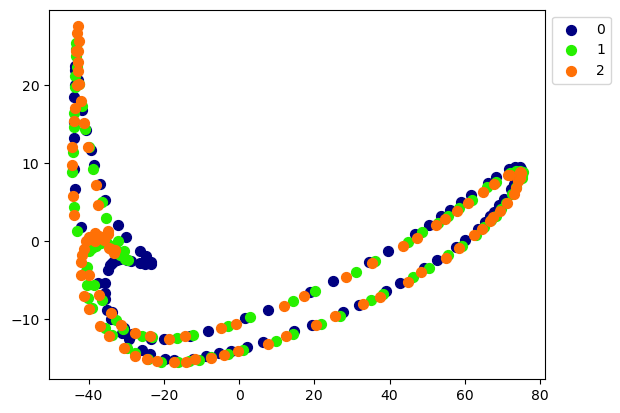

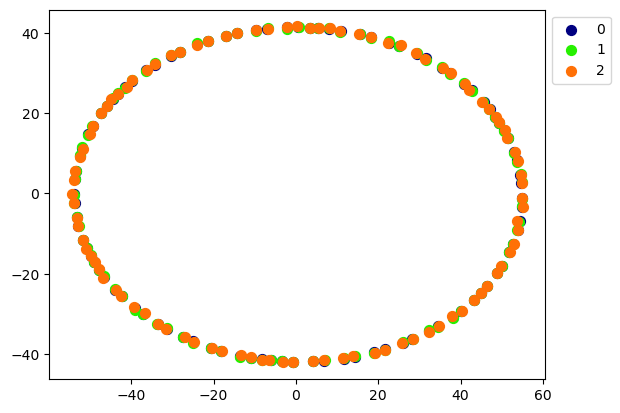

In [51]:
pca_reducer = PCA(n_components=2, random_state=69)

# Apply PCA to your features
embeddings_1 = pca_reducer.fit_transform(feat_1)
embeddings_2 = pca_reducer.fit_transform(feat_2)
embeddings_3 = pca_reducer.fit_transform(X_tensor.cpu().detach().numpy().reshape(97*3, -1))

# Labels
labels = y_gen

# List of embeddings
ems = [embeddings_1, embeddings_2, embeddings_3]

# Plotting
# cmap = plt.cm.get_cmap('tab10', len(np.unique(labels)))  # Colormap for classes

for p in ems:
    embeddings = p
    plt.figure()
    for i in range(np.unique(labels).shape[0]):  # Assuming 10 classes
        indices = labels == np.unique(labels)[i]
        plt.scatter(
            embeddings[indices, 0],
            embeddings[indices, 1],
            label=f'{np.unique(labels)[i]}',
            s=50,
            alpha=1,
            color=cmap(i/len(np.unique(labels)))
        )

    plt.legend(loc='upper left', bbox_to_anchor=(1,1))
    plt.show()

In [52]:
from sklearn.feature_selection import f_classif

In [54]:
f_scores1, p_values1 = f_classif(feat_1, y_gen)
f_scores2, p_values2 = f_classif(feat_2, y_gen)

# for i, (f_score, p_value) in enumerate(zip(f_scores1, p_values1)):
#     print(f"Feature {i}\t{f_score:.4f}\t\t{p_value:.4f}")
# Rank features by F-score
sorted_indices = np.argsort(f_scores1)[::-1]  # Sort in descending order
print("\nFeatures ranked by F-score (highest to lowest):")
for idx in sorted_indices:
    print(f"Feature {idx} (F-score: {f_scores1[idx]:.4f})")

print('\n\n\n')
# for i, (f_score, p_value) in enumerate(zip(f_scores2, p_values2)):
#     print(f"Feature {i}\t{f_score:.4f}\t\t{p_value:.4f}")



Features ranked by F-score (highest to lowest):
Feature 2047 (F-score: nan)
Feature 1751 (F-score: nan)
Feature 1836 (F-score: nan)
Feature 380 (F-score: nan)
Feature 381 (F-score: nan)
Feature 382 (F-score: nan)
Feature 383 (F-score: nan)
Feature 1799 (F-score: nan)
Feature 1798 (F-score: nan)
Feature 1797 (F-score: nan)
Feature 1796 (F-score: nan)
Feature 1750 (F-score: nan)
Feature 1838 (F-score: nan)
Feature 1749 (F-score: nan)
Feature 1748 (F-score: nan)
Feature 1747 (F-score: nan)
Feature 1746 (F-score: nan)
Feature 1745 (F-score: nan)
Feature 1744 (F-score: nan)
Feature 580 (F-score: nan)
Feature 581 (F-score: nan)
Feature 582 (F-score: nan)
Feature 1837 (F-score: nan)
Feature 1839 (F-score: nan)
Feature 1719 (F-score: nan)
Feature 239 (F-score: nan)
Feature 1949 (F-score: nan)
Feature 1948 (F-score: nan)
Feature 1923 (F-score: nan)
Feature 1922 (F-score: nan)
Feature 1921 (F-score: nan)
Feature 1920 (F-score: nan)
Feature 236 (F-score: nan)
Feature 237 (F-score: nan)
Feature 2

/home/fdi/anaconda3/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [  44   45   46   47  108  109  110  111  160  161  162  163  184  185
  186  187  189  190  191  236  237  238  239  320  321  322  323  332
  333  334  335  380  381  382  383  580  581  582  583  672  673  674
  675  724  725  726  727  792  793  794  795  976  977  978  979 1005
 1006 1007 1044 1045 1046 1047 1148 1149 1150 1151 1296 1297 1298 1299
 1340 1341 1342 1343 1488 1489 1490 1491 1496 1497 1498 1499 1716 1717
 1718 1719 1744 1745 1746 1747 1748 1749 1750 1751 1796 1797 1798 1799
 1836 1837 1838 1839 1853 1854 1855 1920 1921 1922 1923 1948 1949 1950
 1951 2044 2045 2046 2047] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/fdi/anaconda3/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/home/fdi

In [71]:
a_1 = model_1(X_tensor)
a_2 = model_2(X_tensor)
_,a_1 = torch.max(a_1,1)
_,a_2 = torch.max(a_2,1)
a_1 = a_1.cpu().detach().numpy()
a_2 = a_2.cpu().detach().numpy()

a_1, a_2

(array([3, 3, 6, 3, 6, 6, 3, 6, 3, 3, 6, 3, 3, 6, 3, 6, 3, 3, 6, 3, 3, 6,
        3, 6, 6, 3, 6, 3, 3, 6, 3, 3, 6, 3, 6, 3, 3, 6, 3, 3, 6, 3, 6, 3,
        3, 6, 3, 3, 6, 3, 6, 6, 3, 6, 3, 3, 6, 3, 3, 6, 3, 6, 3, 3, 6, 3,
        3, 6, 3, 6, 3, 3, 6, 3, 3, 6, 3, 6, 6, 3, 6, 3, 3, 6, 3, 3, 6, 3,
        6, 3, 3, 6, 3, 3, 6, 3, 6, 3, 3, 6, 3, 6, 6, 3, 6, 6, 3, 6, 3, 3,
        6, 3, 6, 6, 3, 6, 3, 3, 6, 3, 6, 6, 3, 6, 3, 3, 6, 3, 6, 6, 3, 6,
        6, 3, 6, 3, 3, 6, 3, 6, 6, 3, 6, 3, 3, 6, 3, 6, 6, 3, 6, 3, 3, 6,
        3, 6, 6, 3, 6, 6, 3, 6, 3, 3, 6, 3, 6, 6, 3, 6, 3, 3, 6, 3, 6, 6,
        3, 6, 6, 3, 6, 3, 3, 6, 3, 6, 6, 3, 6, 3, 3, 6, 3, 6, 3, 3, 6, 3,
        6, 6, 3, 6, 6, 3, 6, 3, 3, 6, 3, 6, 6, 3, 6, 3, 3, 6, 3, 6, 6, 3,
        6, 6, 3, 6, 3, 6, 6, 3, 6, 6, 3, 6, 3, 3, 6, 3, 6, 6, 3, 6, 3, 3,
        6, 3, 6, 6, 3, 6, 6, 3, 6, 3, 6, 6, 3, 6, 6, 3, 6, 3, 3, 6, 3, 6,
        6, 3, 6, 3, 3, 6, 3, 6, 6, 3, 6, 6, 3, 6, 3, 6, 6, 3, 6, 6, 3, 6,
        3, 3, 6, 3, 6]),
 array([6, 3,

## From CWRU to ICMS

### Proposed

In [21]:
model = Network(9,2, cons=1).to(device)

In [22]:
# Load weights
    # Mafaulda  
loaded_sd = torch.load(
        os.path.join(
            '/home/fdi/AliBagheriNejad/Thesis/MECO/code/TLT/weights',
            'cwdw_31_final_1.pth'
        ), map_location=device
    )

model.load_state_dict(loaded_sd)

/tmp/ipykernel_13467/3443653914.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_sd = torch.load(


<All keys matched successfully>

In [23]:

features = extract_second_features(model, X_tensor, device)
features[features.isnan()] = 0

In [27]:
import umap

2025-03-07 15:21:45.648405: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [32]:
umap_reducer = umap.UMAP(n_components=2, random_state=69, n_neighbors=6)
embeddings = umap_reducer.fit_transform(features)

/home/fdi/anaconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/fdi/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


(4.0, 12.0)

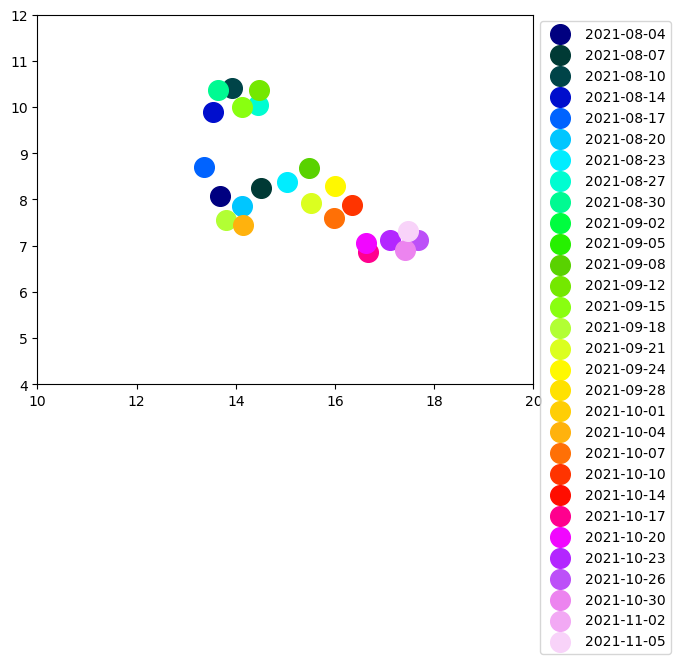

In [34]:

for i in range(np.unique(labels).shape[0]):  # Assuming 10 classes
    indices = labels == np.unique(labels)[i]
    plt.scatter(
        embeddings[indices, 0],
        embeddings[indices, 1],
        label=f'{np.unique(labels)[i]}' ,
        s=200,
        alpha=1,
        color=cmap(i/len(np.unique(labels)))
    )

plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.xlim((10,20))
plt.ylim((4,12))

### Usual

In [35]:
model = NetworkNoReg(9,2, cons=1).to(device)

In [36]:
# Load weights
    # Mafaulda  
loaded_sd = torch.load(
        os.path.join(
            '/home/fdi/AliBagheriNejad/Thesis/MECO/code/TLT/weights',
            'cwdw_31_final_1_noreg.pth'
        ), map_location=device
    )

model.load_state_dict(loaded_sd)

/tmp/ipykernel_13467/3792155716.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_sd = torch.load(


<All keys matched successfully>

In [37]:

features = extract_features(model, X_tensor, device)
features[features.isnan()] = 0

In [38]:
import umap

In [39]:
umap_reducer = umap.UMAP(n_components=2, random_state=69, n_neighbors=6)
embeddings = umap_reducer.fit_transform(features)

/home/fdi/anaconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/fdi/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


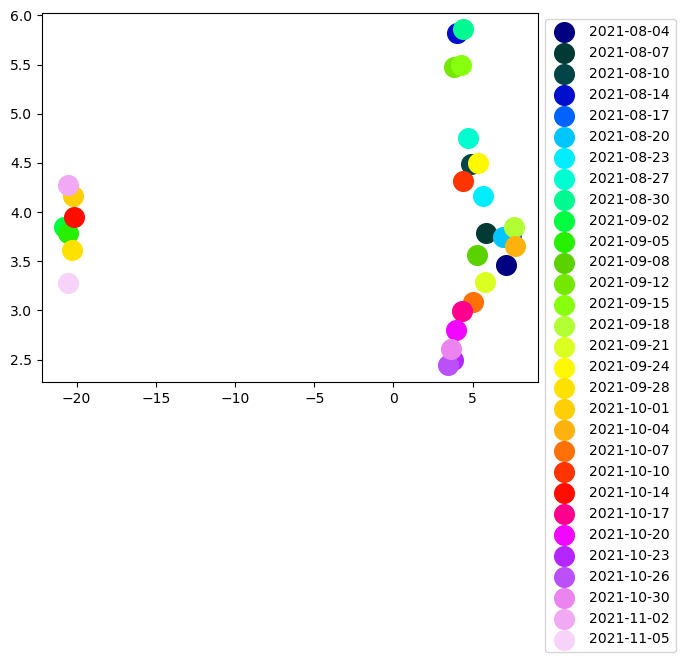

In [41]:

for i in range(np.unique(labels).shape[0]):  # Assuming 10 classes
    indices = labels == np.unique(labels)[i]
    plt.scatter(
        embeddings[indices, 0],
        embeddings[indices, 1],
        label=f'{np.unique(labels)[i]}' ,
        s=200,
        alpha=1,
        color=cmap(i/len(np.unique(labels)))
    )

plt.legend(loc='upper left', bbox_to_anchor=(1,1))
# plt.xlim((6,12))
# plt.ylim((-5,5))